# Depop Price Prediction with CNN-BERT Model

This notebook initializes the model used to predict prices itmes will sell at on my Depop shop, using convolutional layers for images, the pre-trained BERT model for descriptions, and full connected layers for remaining item data: price listed, brand, size. While the hyperparameters set function for my shop, they may need adjustments for different shop data. I will walk through the CNN-BERT setup below.

## Import Packages and Data

My previous data scraping files are constructed to save your data to Google Drive. If you're following the same steps, we need to mount our Drive account so it's connected to Colab.

Then, we import the relevant packages required to run the code.


In [1]:
# Mount to Google Drive so images in Drive can be accessed by Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from IPython.display import Image
from PIL import Image
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from transformers import BertModel, BertTokenizer
from prettytable import PrettyTable

In [3]:
# Read CSV file that contains corresponding item data
data = pd.read_csv('/content/drive/MyDrive/depop_item_details_complete.csv')
data = data.drop(columns=['Image', 'Date', 'Location'])
data.head()

,Description,Price listed,Price sold,Size,Brand
0,🌫️ Vintage hot pink sweater 🌫️ ▫️ Stretchy hot...,US$20.00,US$11.00,M,Cache
1,🌫️ Wool pencil skirt 🌫️ ▫️ Grey wool fabric sh...,US$15.00,US$4.50,4,Ralph Lauren
2,🌫️ Green and Black corset🌫️ ▫️ Gorge iridescen...,US$14.00,US$7.00,30,Other
3,🌫️ Vintage denim mini skirt 🌫️ ▫️ Lighter weig...,US$20.00,US$6.00,6,Calvin Klein
4,🌫️ Wide leg y2k pants 🌫️ ▫️ Thick black fabric...,US$20.00,US$14.00,8,American Vintage


## Prepare Data

Data scraped is not in a neural-network-friendly format. Details like "Size" and "Price listed/sold" have string format, and should be subsequently adjusted, especially if your dataset is small like mine. Thus, we apply the functions below.

Next, neural networks cannot handle images straight up, they must be transformed into an RGB matrix as below.

Lastly, the descriptions as need to be transformed or 'tokenized' so that the neural network can process them. For this step, we introduce the pre-trained BERT model for accessible tokenization.

In [4]:
# Prices pulled from Depop are strings and have undesired 'US$', let's change them to floats for easier calculations
def pricing(price):
    """
    Reformat scraped Depop prices to floats.

    Parameters:
    price (string): Price string from Depop.

    Returns:
    price (float): Price as a float.
    """
    try:
      return float(price.replace('US$', ''))

    except ValueError:
      return price

# Apply pricing function
data['Price listed'] = data['Price listed'].apply(pricing)
data['Price sold'] = data['Price sold'].apply(pricing)

In [5]:
# Sizes pulled from Depop vary too greatly to be useful to NN, so we implement a simple sizing scheme
def sizing(size):
    """
    Find and replace numbered sizing (in womens clothing) and replace values with more discrete sizing scheme.

    Parameters:
    size (string): Raw size string from Depop.

    Returns:
    size (string): Size string converted in scheme.
    """
    try:
      # If size is number, it can be converted into a float, and therefore needs a category defined by the scheme below
      size = float(size)
      if size <= 4:
        return 'XS'

      elif size <= 8 or size == 26: # Note, the 26 is accounting for a pair of jeans in my particular dataset
        return 'S'

      elif size <= 12:
        return 'M'

      elif size <= 16 or size == 30: # Note, the 30 is accounting for a corset in my particular dataset
        return 'L'

      else:
        return 'XL'

    except ValueError:
      # If size isn't a number and contains 'US', it is a shoe
      # Handling this under scheme for now, but should potentially be changed to cater towards shoes (rather than clothing)
      if 'US ' in size:
        size = size.replace('US ', '')

        try:
          return sizing(float(size))

        except ValueError:
          return size

      else:
        return size

# Apply sizing function
data['Size'] = data['Size'].apply(sizing)

In [6]:
# Define transform function to convert image to tensor of proper dimensions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Initialize input_images array to store RGB matrices
input_images = []
indices = np.array(data.index)

# Load each RGB matrix and add to input_images array
for i in indices:
  rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")
  input_images.append(transform(rgb_matrix))

# Add Image column to data
data['Image'] = input_images

In [7]:
# Initialize pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Scale Price listed values to help neural network
scaler = StandardScaler()
data['Price listed'] = scaler.fit_transform(data['Price listed'].values.reshape(-1, 1))

# Perform one-hot encoding on Size and Brand columns together
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform both size and brand columns simultaneously
size_brand_encoded = encoder.fit_transform(data[['Size', 'Brand']])

# Create a DataFrame with the new one-hot encoded columns
encoded_columns = encoder.get_feature_names_out(['Size', 'Brand'])  # Get appropriate column names
df_encoded = pd.DataFrame(size_brand_encoded, columns=encoded_columns)

# Drop original Size and Brand columns from the original DataFrame
data = data.drop(columns=['Size', 'Brand'])

# Concatenate the one-hot encoded columns back to the original DataFrame
data = pd.concat([data.reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## More Preprocessing: Train/Val/Test and Batching

Now we need to split our data into different sets for training, validation, and testing. For more information as to why we do this for neural networks, the following link is helpful:
https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

We are training this neural network using batches, so a collation function and dataset class are handy.

In [8]:
# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=8)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=8)

# Verify dimensions of each dataset
print("Dimensions of train data: ", train_data.shape)
print("Dimensions of validation data: ", val_data.shape)
print("Dimensions of test data: ", test_data.shape)

Dimensions of train data:  (355, 165)
Dimensions of validation data:  (40, 165)
Dimensions of test data:  (99, 165)


In [9]:
# Custom collate function to handle batching of item details
def custom_collate_fn(batch):
    """
    Custom collate function to handle batching of item details: tokenized descriptions, RGB matrices, other features.

    Parameters:
    batch (list): List of data items to be batched.

    Returns:
    dict: Batched data items.
    """

    # Initialize lists to store data for each batch
    images = []
    input_ids = []
    attention_masks = []
    other_features = []
    labels = []

    for item in batch:
        images.append(item['image'])
        input_ids.append(item['input_ids'])
        attention_masks.append(item['attention_mask'])
        other_features.append(item['other_features'])
        labels.append(item['label'])

    images = torch.stack(images)
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    other_features = torch.stack(other_features)
    labels = torch.tensor(labels)

    return {
        'images': images,
        'input_ids': input_ids,
        'attention_masks': attention_masks,
        'other_features': other_features,
        'labels': labels
    }


# Dataset to return dictionary of each item's elements
class DepopDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Define row as iloc for simplicity
        row = self.data.iloc[idx]

        # Load image as a tensor
        image = row['Image'].clone().detach()

        # Tokenize description using BertTokenizer
        description = bert_tokenizer(
            row['Description'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        input_ids = description['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = description['attention_mask'].squeeze(0)  # Remove batch dimension

        # Extract price listed as 1D tensor
        price = torch.tensor(row['Price listed'], dtype=torch.float32).view(1)

        # Extract all columns that match the pattern for one-hot encoded size and brand
        size_columns = [col for col in self.data.columns if col.startswith('Size_')]
        brand_columns = [col for col in self.data.columns if col.startswith('Brand_')]

        # Convert size and brand columns to tensors
        size = torch.tensor(row[size_columns].astype('float32').values, dtype=torch.float32).view(-1)
        brand = torch.tensor(row[brand_columns].astype('float32').values, dtype=torch.float32).view(-1)

        # Combine price with one-hot encoded size and brand
        other_features = torch.cat((price, size, brand), dim=0)

        # Extract label (target price for regression)
        label = torch.tensor(row['Price sold'], dtype=torch.float32).view(1)

        # Return all item details as dictionary
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'other_features': other_features,
            'label': label
        }

In [10]:
# Create DataLoaders for train, validation, and test sets
train_dataset = DepopDataset(train_data)
val_dataset = DepopDataset(val_data)
test_dataset = DepopDataset(test_data)

batch_size = 10  # Adjust as needed

# Instantiate DataLoader with custom collate function
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn) # We only need to shuffle the training dataset
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

## Define Neural Network Architecture

First we will define the DescriptionTransformer class for handling the item descriptions. Note that we load the BERT model here, and unfreeze 40% of the layers at the end of the model, which is necessary for actually training BERT to learn which words in each description are more significant than others.

Next comes the DepopPriceCNN which contains convolutional layers for the images and fully connected layes for the rest of the item details.

In [11]:
# Initialize the DescriptionTransformer to process descriptions of items
class DescriptionTransformer(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_encoder_layers=4):
        super(DescriptionTransformer, self).__init__()

        # Load BERT model
        self.bert_model = BertModel.from_pretrained(bert_model_name)

        # Freeze 60% of the layers in BERT, leaving the last 40% unfrozed for fine-tuning
        for name, param in list(bert_model.named_parameters())[:-79]:
            param.requires_grad = False

        # Transformer encoder layers on top of BERT
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=768, nhead=8, batch_first=True),  # BERT's hidden size is 768
            num_layers=num_encoder_layers
        )

        # Fully connected layers
        self.fc_1 = nn.Linear(768, 256)
        self.fc_2 = nn.Linear(256, 128)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Batch normalization
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)

    def forward(self, input_ids, attention_mask):
        # BERT embeddings
        outputs = self.bert_model(input_ids, attention_mask=attention_mask)
        token_embeddings = outputs.last_hidden_state  # Shape: [batch_size, seq_len, 768]

        # Transformer encoding layers
        x = self.transformer_encoder(token_embeddings)

        # Pooling (weighted average of token embeddings)
        attention_mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size())  # Expand mask shape
        x = (x * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)  # Weighted average across tokens

        # Fully connected layer with dropout and batch normalization
        x = self.fc_1(x)
        x = self.batchnorm1(x)  # Apply batch normalization
        x = self.dropout(x)  # Apply dropout

        x = self.fc_2(x)
        x = self.batchnorm2(x)  # Apply batch normalization
        x = self.dropout(x)  # Apply dropout

        return x


In [12]:
# Initialize DepopPriceCNN, the central NN architecture for processing RGB matrices and other features
class DepopPriceCNN(nn.Module):
    def __init__(self, image_size=128, num_classes=1, conv_channels=[16, 32, 64], fc_image_size=256, fc_other_size=128):
        super(DepopPriceCNN, self).__init__()

        # Build CNN layers
        self.cnn_layers = self.build_cnn_block(conv_channels, in_channels=3)

        # Fully connected layers for the image
        flattened_size = conv_channels[-1] * (image_size // (2 ** len(conv_channels))) ** 2  # Adjust based on CNN output size
        self.fc_image = self.build_fc_block([flattened_size, fc_image_size, 128])

        # Transformer for descriptions
        self.description_transformer = DescriptionTransformer()

        # Fully connected layers for other inputs (price, size, brand)
        self.fc_other = self.build_fc_block([1 + 15 + 146, fc_other_size, 64, 32])

        # Combined layers
        combined_input_size = 128 + 128 + 32  # From image, description, and other inputs
        self.fc_combined = self.build_fc_block([combined_input_size, 128, 64, 32, num_classes], dropout=0.5)

    # Define function for building the CNN layers
    def build_cnn_block(self, channels, in_channels=3):
        layers = []
        for out_channels in channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels  # Set for the next layer
        return nn.Sequential(*layers)

    # Define function for building fully connected layers
    def build_fc_block(self, layer_sizes, dropout=0.5):
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU/Dropout to all except the last layer
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
        return nn.Sequential(*layers)

    def forward(self, image, input_ids, other_features, attention_mask):
        # CNN for image input
        x_image = self.cnn_layers(image)
        x_image = x_image.view(x_image.size(0), -1)  # Flatten image features
        x_image = self.fc_image(x_image)

        # Transformer for description text
        x_description = self.description_transformer(input_ids, attention_mask)

        # Fully connected for other features (price, size, brand)
        x_other = self.fc_other(other_features)

        # Combine all features
        x_combined = torch.cat([x_image, x_description, x_other], dim=1)

        # Final layers for combined input
        output = self.fc_combined(x_combined)

        return output


## Training

Then we initialize lists to keep track of loss and MAPE values, and subsequently train the model. We use the Adam optimizer and learning rate scheduler to help the model converge, but feel free to modify as preferred.

In [19]:
# Initialize Training Loss and Validation Accuracy list
train_loss_list = []
avg_train_loss_list = []
val_loss_list = []

# Lists to store MAPE values for each epoch
train_accuracy_list = []
val_accuracy_list = []

# Initialize PrettyTable to keep track of epoch progress
log_table = PrettyTable(["Epoch", "Training Loss", "Training MAPE", "Validation Loss", "Validation MAPE"])

# Initialize function for calculating MAPE at each stage
def calculate_mape(predictions, actuals):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    actuals (tensor): Actual prices (ground truth).
    predictions (tensor): Predicted prices by the model.

    Returns:
    mape (float): MAPE value as a percentage.
    """
    epsilon = 1e-12  # Small value to prevent division by zero
    percentage_error = torch.abs((actuals - predictions) / (actuals + epsilon)) * 100
    mape = percentage_error.mean().item()  # Take the average over all predictions
    return mape

In [20]:
# Define learning rates preferred for each stage
lr_transformer = 1e-5
lr_cnn = 1e-4
lr_fc = 1e-3

In [21]:
# Initialize the model and loss function
model = DepopPriceCNN()
criterion = nn.MSELoss()

# Define optimizer with different learning rates for different parts of the model
optimizer = optim.Adam([
    {'params': model.cnn_layers.parameters(), 'lr': lr_cnn},
    {'params': model.fc_image.parameters(), 'lr': lr_fc},
    {'params': model.fc_other.parameters(), 'lr': lr_fc},
    {'params': model.fc_combined.parameters(), 'lr': lr_fc},
    {'params': model.description_transformer.parameters(), 'lr': lr_transformer}

], lr=lr_transformer)

# Define the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_mape = 0.0

    for batch in train_loader:
        # Split the batch into its components
        image = batch['images']  # Extract image tensor
        input_ids = batch['input_ids']  # Extract tokenized description (input_ids)
        attention_mask = batch['attention_masks']  # Extract attention masks
        other_features = batch['other_features']  # Extract other features (e.g., price, size, brand)
        labels = batch['labels']  # Extract label (target price)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(image, input_ids, other_features, attention_mask)
        loss = criterion(outputs, labels.view(-1, 1))
        train_loss_list.append(loss.item())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate MAPE for the batch
        batch_mape = calculate_mape(outputs, labels.view(-1, 1))
        running_mape += batch_mape

    # Calculate average train loss and MAPE, then save those items
    avg_train_loss = running_loss / len(train_loader)
    avg_train_mape = running_mape / len(train_loader)
    train_accuracy_list.append(avg_train_mape)
    avg_train_loss_list.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_running_mape = 0.0

    with torch.no_grad():
        for batch in val_loader:
            # Split the batch into its components
            val_image = batch['images']
            val_input_ids = batch['input_ids']
            val_attention_mask = batch['attention_masks']
            val_other_features = batch['other_features']
            val_labels = batch['labels']

            # Evaluate model with validation data
            val_outputs = model(val_image, val_input_ids, val_other_features, val_attention_mask)
            val_loss_item = criterion(val_outputs, val_labels.view(-1, 1)).item()
            val_loss += val_loss_item

            # Calculate MAPE for validation batch
            val_mape_batch = calculate_mape(val_outputs, val_labels.view(-1, 1))
            val_running_mape += val_mape_batch

    # Calculate validation loss and accuracy, and save those items
    avg_val_loss = val_loss / len(val_loader)
    avg_val_mape = val_running_mape / len(val_loader)
    val_loss_list.append(avg_val_loss)
    val_accuracy_list.append(avg_val_mape)

    # Step the scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Combine epoch info in list for table
    log = [epoch + 1, f"{avg_train_loss:.4f}", f"{avg_train_mape:.4f}", f"{avg_val_loss:.4f}", f"{avg_val_mape:.4f}"]

    # If epoch is 0, print the table including table header, else only print the row
    if epoch == 0:
        log_table.add_row(log, divider=True)
        print(log_table)
    else:
        log_table.add_row(log, divider=True)
        row_length = log_table.get_string().find("\n")
        print(log_table.get_string()[-row_length * 3 - 2:])

+-------+---------------+---------------+-----------------+-----------------+
| Epoch | Training Loss | Training MAPE | Validation Loss | Validation MAPE |
+-------+---------------+---------------+-----------------+-----------------+
|   1   |    178.6760   |    91.2497    |     162.7981    |     50.6127     |
+-------+---------------+---------------+-----------------+-----------------+
+-------+---------------+---------------+-----------------+-----------------+
|   2   |    130.0510   |    69.9234    |     106.7337    |     43.0633     |
+-------+---------------+---------------+-----------------+-----------------+
+-------+---------------+---------------+-----------------+-----------------+
|   3   |    139.8337   |    81.9819    |     141.3958    |     47.0828     |
+-------+---------------+---------------+-----------------+-----------------+
+-------+---------------+---------------+-----------------+-----------------+
|   4   |    118.5293   |    73.3596    |     110.5251    |     

## Evaluating and Visualizing Results

Post training we need to see how the model performs on our test set, which involves plotting the loss and MAPE accuracy over epochs, plotting the residuals, and visualizing the model's best and worst predictions on the test set.

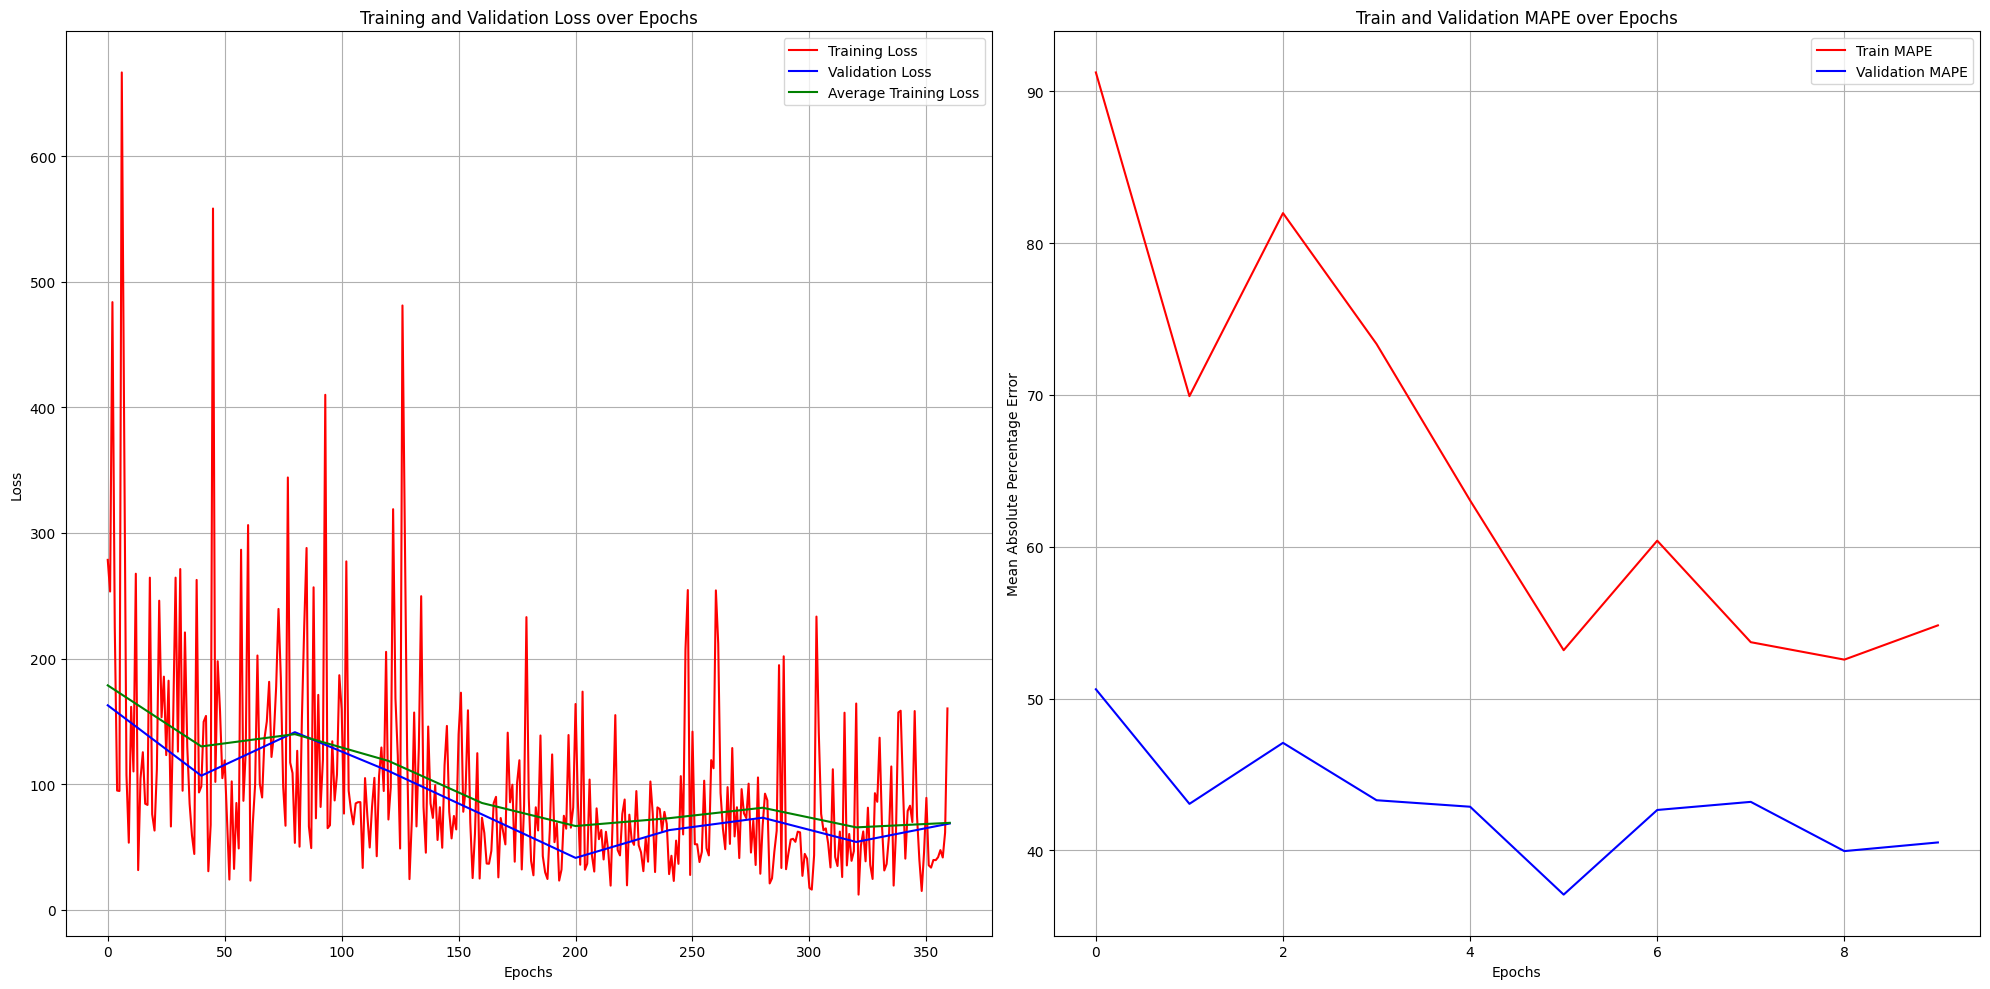

In [22]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the training and validation loss
ax1.plot(train_loss_list, color='red', label='Training Loss')
ax1.plot(np.linspace(0, len(train_loss_list), len(val_loss_list)), val_loss_list, color='blue', label='Validation Loss')
ax1.plot(np.linspace(0, len(train_loss_list), len(avg_train_loss_list)), avg_train_loss_list, color='green', label='Average Training Loss')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title('Training and Validation Loss over Epochs')
ax1.legend()
ax1.grid(True)

# Plot the training and validation MAPE
ax2.plot(train_accuracy_list, label='Train MAPE', color='red')
ax2.plot(val_accuracy_list, label='Validation MAPE', color='blue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Mean Absolute Percentage Error')
ax2.set_title('Train and Validation MAPE over Epochs')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [23]:
# Evaluation on the test set
model.eval()
test_loss = 0.0
predictions = []
actuals = []
with torch.no_grad():
    for test_batch in test_loader:
        # Split the batch into its components
        test_image = test_batch['images']
        test_input_ids = test_batch['input_ids']
        test_attention_mask = test_batch['attention_masks']
        test_other_features = test_batch['other_features']
        test_label = test_batch['labels']

        # Pass test data through model
        test_outputs = model(test_image, test_input_ids, test_other_features, test_attention_mask)
        test_loss += criterion(test_outputs, test_label.view(-1, 1)).item()

        # Save actual and predicted values to lists for later visualization
        predictions.extend(test_outputs.view(-1).cpu().numpy())
        actuals.extend(test_label.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 37.2372


In [24]:
# Calculate MAPE value on our test set
mape_value = calculate_mape(torch.tensor(predictions), torch.tensor(actuals))

# Round MAPE value for use in model file name
mape_value = round(mape_value)
print(f'Testing Mean Absolute Percentage Error (MAPE): {mape_value}%')

Testing Mean Absolute Percentage Error (MAPE): 33%


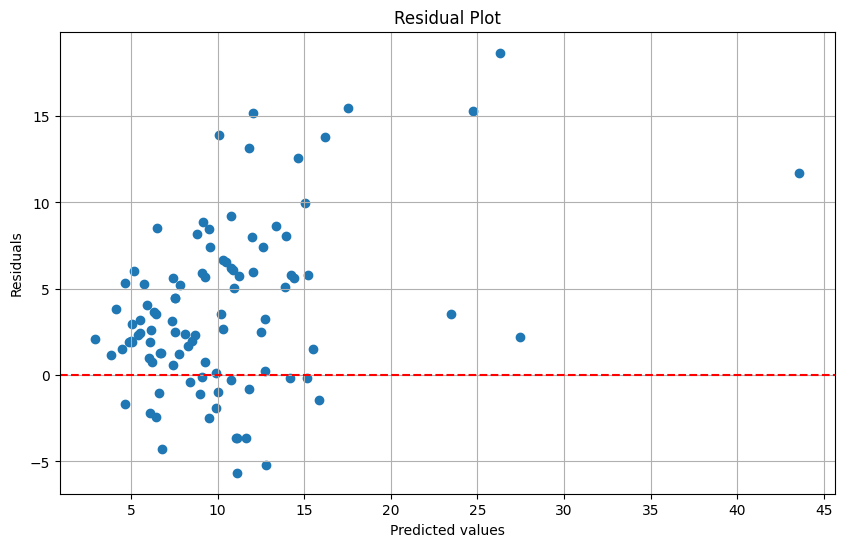

In [25]:
# Calculate residuals of test set
preds = np.array(predictions)
true = np.array(actuals)
residuals = true - preds

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(preds, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [26]:
# Visualize best/worst predictions including their images
num_samples = 3  # Adjust based on how many you want to see

# Define results dataframe, as pandas has nice min/max functions
results = pd.DataFrame({'Item': test_data.index, 'Image': test_data['Image'], 'Predicted': predictions, 'Actual': actuals, 'MAPE': np.abs((np.array(actuals) - np.array(predictions)) / (np.array(actuals) + 1e-12)) * 100})

# Initialize lists to store best/worst predictions
best_list = []
worst_list = []

for i in range(num_samples):
    # Find items with highest/lowest MAPE values
    best_item = results.loc[results['MAPE'].idxmin()]
    worst_item = results.loc[results['MAPE'].idxmax()]

    # Append lists with item details
    best_list.append({'Image': best_item['Image'], 'Predicted': best_item['Predicted'], 'Actual': best_item['Actual']})
    worst_list.append({'Image': worst_item['Image'], 'Predicted': worst_item['Predicted'], 'Actual': worst_item['Actual']})

    # Drop those items for subsequent calculations
    results = results.drop([best_item.name, worst_item.name])

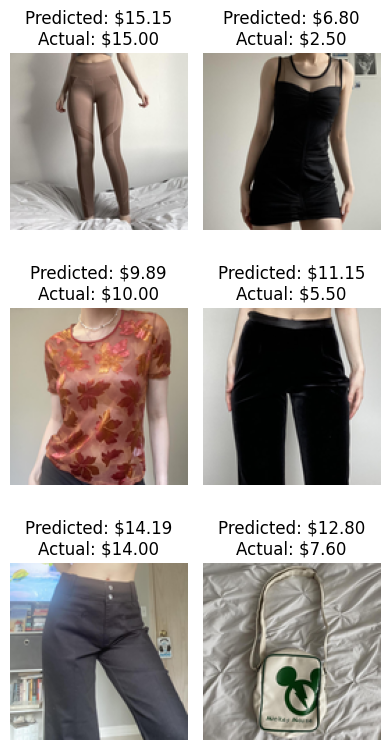

In [29]:
# Define the mean and std values used for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Function to reverse normalization
def reverse_normalize(tensor):
    return tensor * std[:, None, None] + mean[:, None, None]

# Initialize figure for visualization
fig = plt.figure(figsize=(4, 8))
spec = mpl.gridspec.GridSpec(ncols=2, nrows=num_samples)

# Loop through each best/worst prediction and plot
for i  in range(num_samples * 2):
    # Depending on the parity of i, we know if we're plotting a best or worst prediction
    if i % 2 == 1:
        ref_list = worst_list
        j = 1 # Odd parity on the right (worst)
    else:
        ref_list = best_list
        j = 0 # Even parity on the left (best)

    # Extract image and values for plotting
    image_tensor = ref_list[i // 2]['Image']
    actual_price = ref_list[i // 2]['Actual'].item()  # Ensure it's a scalar
    predicted_price = ref_list[i // 2]['Predicted'].item()  # Ensure it's a scalar
    image = image_tensor.view(3, 128, 128)  # Reshape to (C, H, W)
    image = reverse_normalize(image)  # Apply reverse normalization

    # Transpose image to HxWxC for visualization
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC for plt.imshow

    # Plot the image and data values
    ax = fig.add_subplot(spec[i // 2, j])
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide axes
    plt.title(f'Predicted: ${predicted_price:.2f}\nActual: ${actual_price:.2f}')  # Show prices

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# After training, save the model's state_dict to Google Drive
save_path = f'/content/drive/MyDrive/depop_model_{mape_value}.pth'
torch.save(model.state_dict(), save_path)